In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar, Profiler
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output


In [2]:
ddir = '/swot/SUM03/tmp/CESM/'

In [3]:
client = Client('tcp://129.236.21.48:8089')
client

Client Scheduler: tcp://129.236.21.48:8089 Dashboard: http://129.236.21.48:8787/status,Cluster Workers: 16 Cores: 16 Memory: 8.66 TB


In [4]:
ds=xr.open_zarr(ddir+'hybrid_v5_rel04_BC5_ne120_t12_pop62', auto_chunk=False).chunk({'time': 1})
ds

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    ANGLET              (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DXU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYT                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    DYU                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HT                  (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTE                 (nlat, nlon) float64 dask.array<shape=(2400, 3600), chunksize=(2400, 3600)>
    HTN                 (nlat, nlon) float64 dask.

In [5]:
from xbatcher import BatchGenerator

In [6]:
ds=ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

In [7]:
def threeD_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

def extract_needed_variables(batch):
    shift_vars = ['SSH','XU','YU']
    coord_vars = ['XU','YU']

    shifts = {'_e': dict(nlon_input=-1),
              '_w': dict(nlon_input=1),
             '_n': dict(nlat_input=-1),
             '_s': dict(nlat_input=1),
             '_ne': dict(nlon_input=-1,nlat_input=-1),
             '_nw': dict(nlon_input=1,nlat_input=-1),
             '_se': dict(nlon_input=-1,nlat_input=1),
             '_sw': dict(nlon_input=1,nlat_input=1),}

    for suf, shift in shifts.items():
        for var in shift_vars:
            batch[var + suf] = batch[var].shift(**shift)
            
    suffixes = ['','_e','_w','_n','_s','_ne','_nw','_se','_sw']
    for suf in suffixes:
        batch['X'+suf],batch['Y'+suf],batch['Z'+suf], = threeD_coords(batch['XU'+suf],batch['YU'+suf])
    for var in coord_vars:
        for suf in suffixes:
            batch = batch.drop([var+suf])
    return batch

targets=['U','V']
feature_cols = ['X', 'Y', 'Z',
                'X_e','X_w','X_n','X_s','X_ne','X_se','X_nw','X_sw',
                'Y_e','Y_w','Y_n','Y_s','Y_ne','Y_se','Y_nw','Y_sw',
                'Z_e','Z_w','Z_n','Z_s','Z_ne','Z_se','Z_nw','Z_sw',
                'TAUX','TAUY','SST','SSH',
                'SSH_e','SSH_w','SSH_n','SSH_s','SSH_ne','SSH_se','SSH_nw','SSH_sw']
from sklearn.model_selection import train_test_split

def ds_to_df(batch, w_validation=False, choice='training'):
    #df = batch.reset_index('sample').to_dataframe()
    #X = df.dropna().reset_index(drop=True).loc[:, feature_cols]
    #y = df.dropna().reset_index(drop=True).loc[:, targets]
    df = batch.drop('sample').to_dataframe().dropna().reset_index(drop=True)
    X = df.loc[:, feature_cols]
    y = df.loc[:, targets]
    
    if w_validation:
        X,X_t,y,y_t = train_test_split(X,y,test_size=0.2)
        if (choice=='training'):
            return (X,y)
        elif (choice=='validation'):
            return (X_t,y_t)
    else:
        return (X,y)
    

In [8]:
vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 600, 'nlat': 600}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=True)
for it, batch in enumerate(bg):
    #yield  ds_to_df(extract_needed_variables(batch))
    break

In [9]:
vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 600, 'nlat': 600}, batch_dims={'time': 1},
                    input_overlap={'nlon' : 1, 'nlat' : 1},
                    concat_input_dims=False)
for it, batch in enumerate(bg):
    #yield  ds_to_df(extract_needed_variables(batch))
    break

In [39]:
batch

<xarray.Dataset>
Dimensions:  (nlat: 600, nlon: 600, time: 1)
Coordinates:
  * time     (time) object   46-01-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (time, nlat, nlon) float32 nan nan nan ... 5.933918 5.836371
    SSH      (time, nlat, nlon) float32 nan nan nan ... -97.005005 -99.86085
    TAUX     (time, nlat, nlon) float32 nan nan nan ... 1.0427505 1.0210682
    TAUY     (time, nlat, nlon) float32 nan nan nan ... 0.42712307 0.41246045
    XU       (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -50.2 -50.1 -50.0
    YU       (nlat, nlon) float64 -1.0 -1.0 -1.0 -1.0 ... -50.2 -50.2 -50.2
    U        (time, nlat, nlon) float32 nan nan nan ... -15.661046 -13.971774
    V        (time, nlat, nlon) float32 nan nan nan ... 39.552116 38.541576
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable 

In [45]:
for jt in range(len(batch.sample)):
    bt = batch.isel(sample=jt)
    break

In [48]:
dset = extract_needed_variables(bt)

In [58]:
df = dset.drop('sample').to_dataframe().dropna().reset_index(drop=True)

In [60]:
df.head()

,SST,SSH,TAUX,TAUY,U,V,SSH_e,SSH_w,SSH_n,SSH_s,...,Z_ne,X_nw,Y_nw,Z_nw,X_se,Y_se,Z_se,X_sw,Y_sw,Z_sw
0,-1.534653,-164.583984,0.003066,-0.012286,-5.393175,1.885184,-164.623947,-164.431229,-165.003525,-164.283218,...,-0.147969,-0.972915,-0.178114,-0.147349,-0.973255,-0.176496,-0.147051,-0.973255,-0.177008,-0.146434
1,-1.530927,-164.623947,-0.004285,-0.008224,-5.137850,1.260170,-164.729080,-164.583984,-165.110397,-164.343765,...,-0.148279,-0.972915,-0.177856,-0.147659,-0.973255,-0.176239,-0.147358,-0.973255,-0.176752,-0.146742
2,-1.532156,-164.729080,-0.011821,-0.008574,-4.816847,1.334423,-164.734955,-164.623947,-165.086456,-164.272980,...,-0.148589,-0.972915,-0.177598,-0.147969,-0.973255,-0.175981,-0.147666,-0.973255,-0.176496,-0.147051
3,-1.581906,-164.734467,0.011250,-0.025872,-4.676420,3.361807,-164.981033,-164.696213,-165.245071,-164.549179,...,-0.147806,-0.972744,-0.179182,-0.147181,-0.973085,-0.177561,-0.146891,-0.973085,-0.178073,-0.146270
4,-1.566659,-164.981033,0.001306,-0.011417,-4.285997,1.558790,-165.003525,-164.734467,-165.274368,-164.431229,...,-0.148118,-0.972744,-0.178924,-0.147494,-0.973085,-0.177304,-0.147201,-0.973085,-0.177817,-0.146581


In [53]:
df = dset.to_dataframe()

In [54]:
df.head()

SST  SSH  TAUX  TAUY   U   V                    sample  \
nlat_input nlon_input                                                           
0          0           NaN  NaN   NaN   NaN NaN NaN  (  46-01-02 00:00:00, 0)   
           1           NaN  NaN   NaN   NaN NaN NaN  (  46-01-02 00:00:00, 0)   
           2           NaN  NaN   NaN   NaN NaN NaN  (  46-01-02 00:00:00, 0)   
           3           NaN  NaN   NaN   NaN NaN NaN  (  46-01-02 00:00:00, 0)   
           4           NaN  NaN   NaN   NaN NaN NaN  (  46-01-02 00:00:00, 0)   

                       SSH_e  SSH_w  SSH_n  ...       Z_ne      X_nw     Y_nw  \
nlat_input nlon_input                       ...                                 
0          0             NaN    NaN    NaN  ...  -0.999695       NaN      NaN   
           1             NaN    NaN    NaN  ...  -0.999695 -0.017452 -0.01745   
           2             NaN    NaN    NaN  ...  -0.999695 -0.017452 -0.01745   
           3             NaN    NaN    NaN  ...  -0.999695 -0.017452 -0.01745   
           4             NaN    NaN    NaN  ...  -0.999695 -0.017452 -0.01745   

                           Z_nw  X_se  Y_se  Z_se  X_sw  Y_sw  Z_sw  
nlat_input nlon_input                                                
0          0                NaN   NaN   NaN   NaN   NaN   NaN   NaN  
           1          -0.999695   NaN   NaN   NaN   NaN   NaN   NaN  
           2          -0.999695   NaN   NaN   NaN   NaN   NaN   NaN  
           3          -0.999695   NaN   NaN   NaN   NaN   NaN   NaN  
           4          -0.999695   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 42 columns]

In [13]:
sam

<xarray.DataArray 'sample' ()>
array((netcdftime._netcdftime.DatetimeNoLeap(46, 1, 2, 0, 0, 0, 0, 0, 2), 0),
      dtype=object)
Coordinates:
    sample   object (netcdftime._netcdftime.DatetimeNoLeap(46, 1, 2, 0, 0, 0, 0, 0, 2), 0)

In [10]:
def actual_generator(**kwargs):
    vars_wanted = ['SST','SSH', 'TAUX','TAUY','XU', 'YU','U','V']
    bg = BatchGenerator(ds.reset_coords()[vars_wanted],
                    input_dims={'nlon': 600, 'nlat': 600}, batch_dims={'time': 1},
                    concat_input_dims=True)
    for batch in bg:
        for jt in range(len(batch.sample)):
            bt = batch.isel(sample=jt)
            yield  ds_to_df(extract_needed_variables(bt), kwargs)

In [11]:
import tensorflow as tf
from tensorflow import keras

/home/as4479/new_miniconda/miniconda/envs/pangeo/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu,
                       input_shape=(len(feature_cols),),
                       name='hidden_layer_1',),
    keras.layers.Dense(20, activation=tf.nn.relu, 
                       name='hidden_layer_2'),
    keras.layers.Dense(10, activation=tf.nn.relu, 
                       name='hidden_layer_3'),
    keras.layers.Dense(2, name='output_layer',)
])

# Define your optimizer asdf
#optimizer = tf.train.AdamOptimizer()
model.compile(loss='mse',
            optimizer='adam',
            metrics=['mae', 'mse','accuracy'])

# show a summary of the data
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_1 (Dense)       (None, 40)                1600      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 20)                820       
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 10)                210       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 22        
Total params: 2,652
Trainable params: 2,652
Non-trainable params: 0
_________________________________________________________________


In [13]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

lw=2
aph=.2

plt.rcParams['figure.figsize'] = (14.,5.)



In [14]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# updatable plot
# a minimal example (sort of)

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('acc'))
        self.val_accuracy.append(logs.get('val_acc'))
        
        self.i += 1
        
        clear_output(wait=True)
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Mean Square Error');
        plt.subplot(122)
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.xlabel('Epoch');
        plt.ylabel('Model Accuracy');
        plt.show();
        
plot_losses = PlotLosses()

# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])

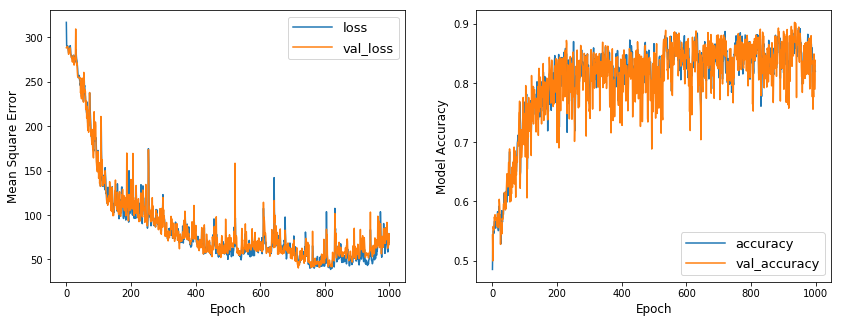

24/24 [==============================] - 51s 2s/step - loss: 68.4801 - mean_absolute_error: 5.0645 - mean_squared_error: 68.4801 - acc: 0.8179 - val_loss: 66.9158 - val_mean_absolute_error: 4.7962 - val_mean_squared_error: 66.9158 - val_acc: 0.8379


In [15]:
model_hist = model.fit_generator(generator=actual_generator(w_validation=True, choice='training'),
                                 validation_data=actual_generator(w_validation=True, choice='validation'),
                                 steps_per_epoch=24, validation_steps=24, epochs=1000, callbacks=[plot_losses])#, use_multiprocessing=True, workers=10)


In [44]:
#plt.rcParams['figure.figsize'] = (14.,5.)
def plot_history(history, xlim=[0,1000]):
    plt.figure(figsize=(18,4))
    plt.subplot(131)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Mean squared error)')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([20, 350])
    plt.xlim(xlim)
    plt.subplot(132)
    plt.xlabel('Epoch')
    plt.ylabel(r'Mean Abs Error [$cm/s$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Validation')
    plt.legend()
    plt.ylim([3, 13])
    plt.xlim(xlim)

    plt.subplot(133)
    plt.xlabel('Epoch')
    plt.ylabel(r'Model Accuracy [$\%$]')
    plt.plot(history.epoch, np.array(history.history['acc']),
           label='Training')
    plt.plot(history.epoch, np.array(history.history['val_acc']),
           label = 'Validation')
    plt.legend()
    plt.ylim([0.4, 0.95])
    plt.xlim(xlim)


In [45]:
print(model_hist.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_acc', 'loss', 'mean_absolute_error', 'mean_squared_error', 'acc'])


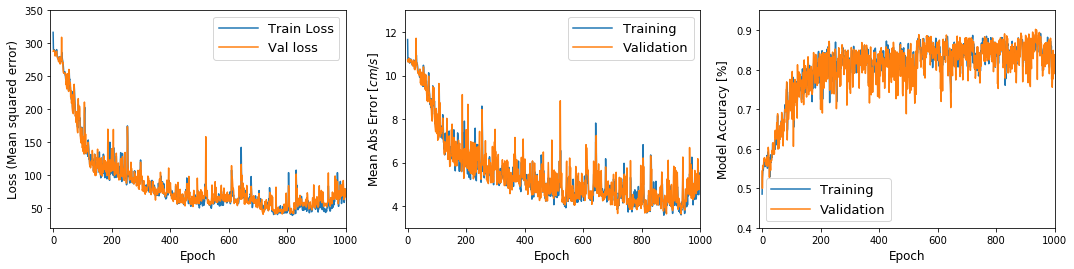

In [49]:
plot_history(model_hist, xlim=[-10,1000])
plt.savefig('Figs_regression/NN3layer_train_globe_600batch_1dperepoch.pdf')

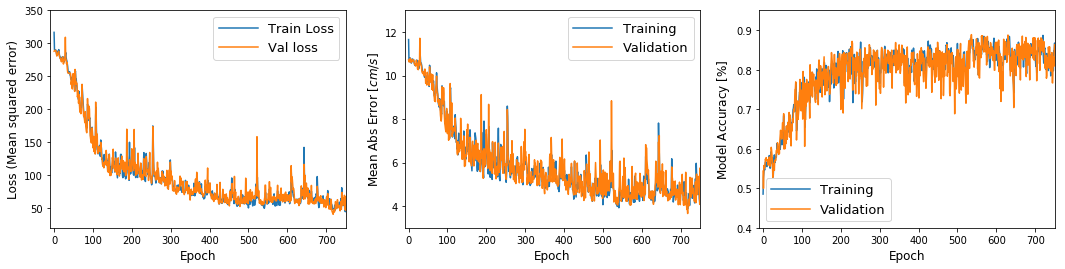

In [50]:
plot_history(model_hist, xlim=[-10,750])
plt.savefig('Figs_regression/NN3layer_train_globe_600batch_1dperepoch_clipped.pdf')

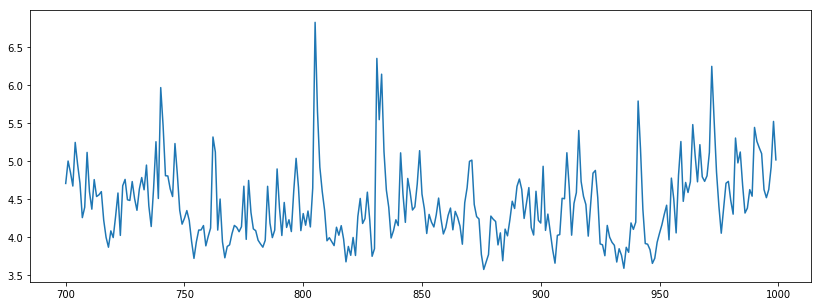

In [26]:
plt.plot(model_hist.epoch[700:],np.array(model_hist.history['mean_absolute_error'])[700:])

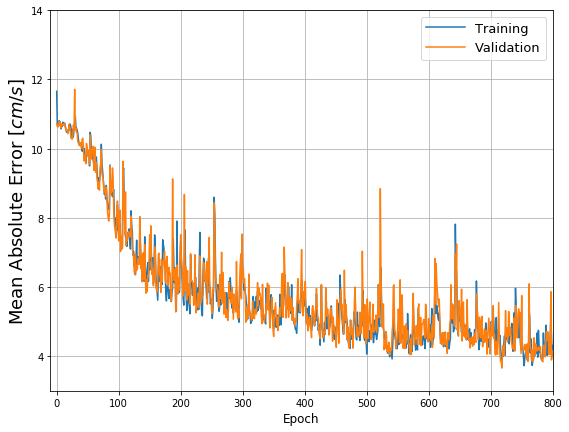

In [58]:
plt.figure(figsize=(9,7))
plt.plot(model_hist.epoch, np.array(model_hist.history['mean_absolute_error']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_mean_absolute_error']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Absolute Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,800])
plt.ylim([3,14])
plt.grid()

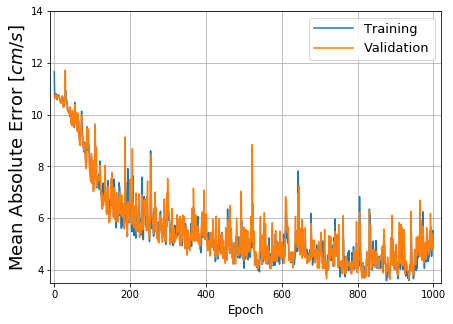

In [62]:
plt.figure(figsize=(7,5))
plt.plot(model_hist.epoch, np.array(model_hist.history['mean_absolute_error']), label='Training')
plt.plot(model_hist.epoch, np.array(model_hist.history['val_mean_absolute_error']), label='Validation')
plt.xlabel('Epoch')
plt.ylabel(r'Mean Absolute Error [$cm/s$]', fontsize=18)
plt.legend()
plt.xlim([-10,1020])
plt.ylim([3.5,14])
plt.grid()

plt.savefig('Figs_regression/NN3layer_MAE_train_globe_600batch_1dperepoch.pdf')

In [27]:
model.save_weights('./model_checkpoints/weights_batch600_3layer_402010_1000d')
model.save('./model_checkpoints/model_batch600_3layer_402010_1000d')

In [55]:
import pickle

In [56]:
with open('./model_checkpoints/History_batch600_3layer_402010_1000d', 'wb') as file_pi:
        pickle.dump(model_hist.history, file_pi)


In [47]:
model.weights

[<tf.Variable 'hidden_layer_1/kernel:0' shape=(39, 40) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_1/bias:0' shape=(40,) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_2/kernel:0' shape=(40, 20) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_2/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_3/kernel:0' shape=(20, 10) dtype=float32_ref>,
 <tf.Variable 'hidden_layer_3/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'output_layer/kernel:0' shape=(10, 2) dtype=float32_ref>,
 <tf.Variable 'output_layer/bias:0' shape=(2,) dtype=float32_ref>]

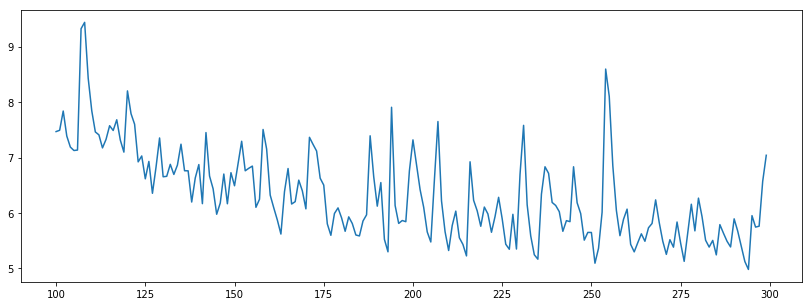

In [29]:
plt.plot(model_hist.epoch[100:300],np.array(model_hist.history['mean_absolute_error'])[100:300])